# **Simulations in Garfield++ with open source finite element calculations**

The finite element method can be used to compute a numerical solution for the electrical potential in a detector setup given the geometry and applied voltages. The main steps are:

1. Define the geometry

<img src="https://raw.githubusercontent.com/jerenner/garfieldfem/master/figures/LEM_geo.png" width=400>

2. Mesh the geometry (discretize the space over which the geometry is defined)

<img src="https://raw.githubusercontent.com/jerenner/garfieldfem/master/figures/LEM_mesh.png" width=400>

3. Use a FEM solver to determine the solution over the entire mesh

4. Import the mesh and FEM solution into Garfield++

For further information see: https://garfieldpp.web.cern.ch/garfieldpp/examples/elmer/garfield_elmer_doc.pdf



# Set up the environment
The software we will use includes:
- Gmsh -- https://gmsh.info: for defining our detector geometry and creating a finite element mesh
- Elmer -- http://www.elmerfem.org: for solving for the electrostatic fields
- ROOT -- https://root.cern.ch: a prerequisite for Garfield++ (with Python enabled). Note that for this example a version of ROOT has been compiled with Python 3.
- Garfield++ -- https://garfieldpp.web.cern.ch/garfieldpp: for detector simulation

The entire development environment has already been prepared to run the code in this notebook on Google Colab and will be downloaded directly below. This setup is documented in another notebook:

https://colab.research.google.com/github/jerenner/garfieldfem/blob/master/garfield_FEM_install.ipynb

It can be followed to perform a similar installation on a local machine.

**Get the pre-compiled binaries**

In [1]:
!wget https://www.dropbox.com/s/ron3hjegmwu7ram/environ.tar.gz
!tar -xvf environ.tar.gz
!apt-get install libgsl-dev

Streaming output truncated to the last 5000 lines.
root/install/etc/cling/lib/clang/5.0.0/include/__stddef_max_align_t.h
root/install/etc/cling/lib/clang/5.0.0/include/clzerointrin.h
root/install/etc/cling/lib/clang/5.0.0/include/stdlib.h
root/install/etc/cling/lib/clang/5.0.0/include/avx512vpopcntdqintrin.h
root/install/etc/cling/lib/clang/5.0.0/include/htmintrin.h
root/install/etc/cling/lib/clang/5.0.0/include/bmi2intrin.h
root/install/etc/cling/lib/clang/5.0.0/include/avx512fintrin.h
root/install/etc/cling/lib/clang/5.0.0/include/xsaveoptintrin.h
root/install/etc/cling/lib/clang/5.0.0/include/xsaveintrin.h
root/install/etc/cling/lib/clang/5.0.0/include/stdatomic.h
root/install/etc/cling/lib/clang/5.0.0/include/rtmintrin.h
root/install/etc/cling/lib/clang/5.0.0/include/immintrin.h
root/install/etc/cling/lib/clang/5.0.0/include/armintr.h
root/install/etc/cling/lib/clang/5.0.0/include/mmintrin.h
root/install/etc/cling/lib/clang/5.0.0/include/stdnoreturn.h
root/install/etc/cling/lib/cla

**Set environment variables and load the necessary libraries**

In [2]:
import numpy as np

# Set the environment variables.
import os
os.environ["GARFIELD_HOME"] = "/content/garfield/garfieldpp"
os.environ["ROOTSYS"] = "/content/root/install"
os.environ["PATH"] += ":/content/elmer/install/bin:/content/gmsh/bin"

# Load the ROOT and Garfield libraries.
import sys
sys.path.append("/content/root/install/lib")

import ctypes
ctypes.cdll.LoadLibrary('/content/root/install/lib/libCore.so')
ctypes.cdll.LoadLibrary('/content/root/install/lib/libThread.so')
ctypes.cdll.LoadLibrary('/content/root/install/lib/libtbb.so.2')
ctypes.cdll.LoadLibrary('/content/root/install/lib/libImt.so')
ctypes.cdll.LoadLibrary('/content/root/install/lib/libRIO.so')
ctypes.cdll.LoadLibrary('/content/root/install/lib/libNet.so')
ctypes.cdll.LoadLibrary('/content/root/install/lib/libTree.so')
ctypes.cdll.LoadLibrary('/content/root/install/lib/libMathCore.so')
ctypes.cdll.LoadLibrary('/content/root/install/lib/libMatrix.so')
ctypes.cdll.LoadLibrary('/content/root/install/lib/libHist.so')
ctypes.cdll.LoadLibrary('/content/root/install/lib/libGeom.so')
ctypes.cdll.LoadLibrary('/content/root/install/lib/libXMLIO.so')
ctypes.cdll.LoadLibrary('/content/root/install/lib/libGdml.so')
ctypes.cdll.LoadLibrary('/content/root/install/lib/libGraf.so')
ctypes.cdll.LoadLibrary('/content/root/install/lib/libGpad.so')
ctypes.cdll.LoadLibrary('/content/root/install/lib/libGraf3d.so')
ctypes.cdll.LoadLibrary('/content/root/install/lib/libcppyy_backend3_7.so')

import ROOT
ROOT.gSystem.Load("/content/garfield/install/lib/libGarfield.so")
%jsroot off

# Change the working directory.
working_dir = "/content/examples"
if(not os.path.isdir(working_dir)):
  os.mkdir(working_dir)
os.chdir(working_dir)

Welcome to JupyROOT 6.22/02


# **1. 2D wire example**

## Create the FEM map

#### Create the geometry file
Note that currently Garfield++ only supports 2D meshes with second-order, 8-node quadrilateral elements. One way of ensuring that the mesh is composed of these elements is by using the following commands (see https://gmsh.info/doc/texinfo/gmsh.html#Mesh-options-list):

```
Mesh.RecombinationAlgorithm = 2;
Mesh.ElementOrder = 2;
Mesh.SecondOrderIncomplete = 1;
Mesh.SubdivisionAlgorithm = 1;

Mesh 2;
RecombineMesh;
RefineMesh;
```

In [3]:
wire2d_geo_text = """//
// Create a 2D wire geometry
s = 10;  // side length of enclosing region
r = 1;   // radius of wire

lcBoundary = 0.4;  // characteristic length near enclosing region
lcWire = 0.4;      // characteristic length near wire

// Create the bounding box.
pbox0 = newp; Point(pbox0) = {-s/2, s/2,  0, lcBoundary};
pbox1 = newp; Point(pbox1) = {s/2,  s/2,  0, lcBoundary};
pbox2 = newp; Point(pbox2) = {s/2,  -s/2, 0, lcBoundary};
pbox3 = newp; Point(pbox3) = {-s/2, -s/2, 0, lcBoundary};
lbox0 = newc; Line(lbox0)  = {pbox0, pbox1};
lbox1 = newc; Line(lbox1)  = {pbox1, pbox2};
lbox2 = newc; Line(lbox2)  = {pbox2, pbox3};
lbox3 = newc; Line(lbox3)  = {pbox3, pbox0};
llbox = newreg; Line Loop(llbox) = {lbox0, lbox1, lbox2, lbox3};

// Create the wire.
pcenter = newp; Point(pcenter) = {0,  0,  0, lcWire};
pwire0 = newp; Point(pwire0) = {r,  0,  0, lcWire};
pwire1 = newp; Point(pwire1) = {0,  -r, 0, lcWire};
pwire2 = newp; Point(pwire2) = {-r, 0,  0, lcWire};
pwire3 = newp; Point(pwire3) = {0,  r,  0, lcWire};
cwire0 = newc; Circle(cwire0) = {pwire0, pcenter, pwire1};
cwire1 = newc; Circle(cwire1) = {pwire1, pcenter, pwire2};
cwire2 = newc; Circle(cwire2) = {pwire2, pcenter, pwire3};
cwire3 = newc; Circle(cwire3) = {pwire3, pcenter, pwire0};
llwire = newreg; Line Loop(llwire) = {cwire0, cwire1, cwire2, cwire3};

// Create the surfaces.
physcbox = newreg; Physical Curve(physcbox) = {lbox0, lbox1, lbox2, lbox3};
psbox  = newreg; Plane Surface(psbox) = {llbox, llwire};
physsbox = newreg; Physical Surface(physsbox) = {psbox};

physcwire = newreg; Physical Curve(physcwire) = {cwire0, cwire1, cwire2, cwire3};
pswire = newreg; Plane Surface(pswire) = {llwire};
physswire = newreg; Physical Surface(physswire) = {pswire};

Mesh.RecombinationAlgorithm = 2;
Mesh.ElementOrder = 2;
Mesh.SecondOrderIncomplete = 1;
Mesh.SubdivisionAlgorithm = 1;

Mesh 2;
RecombineMesh;
RefineMesh;
"""

wire2d_geo_file = open("wire2d.geo", "w")
wire2d_geo_file.write(wire2d_geo_text)
wire2d_geo_file.close()

#### Create the mesh with Gmsh

In [4]:
!gmsh wire2d.geo -2 -order 2

Info    : Running 'gmsh wire2d.geo -2 -order 2' [Gmsh 4.5.6, 1 node, max. 1 thread]
Info    : Started on Wed Mar 10 23:31:39 2021
Info    : Reading 'wire2d.geo'...
Info    : Meshing 1D...
Info    : [  0 %] Meshing curve 1 (Line)
Info    : [ 20 %] Meshing curve 2 (Line)
Info    : [ 30 %] Meshing curve 3 (Line)
Info    : [ 40 %] Meshing curve 4 (Line)
Info    : [ 50 %] Meshing curve 6 (Circle)
Info    : [ 70 %] Meshing curve 7 (Circle)
Info    : [ 80 %] Meshing curve 8 (Circle)
Info    : [ 90 %] Meshing curve 9 (Circle)
Info    : Done meshing 1D (0.001454 s)
Info    : Meshing 2D...
Info    : [  0 %] Meshing surface 12 (Plane, Frontal-Delaunay)
Info    : [ 50 %] Meshing surface 15 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (0.044677 s)
Info    : Refining mesh...
Info    : Meshing order 2 (curvilinear on)...
Info    : [  0 %] Meshing curve 1 order 2
Info    : [ 10 %] Meshing curve 2 order 2
Info    : [ 20 %] Meshing curve 3 order 2
Info    : [ 30 %] Meshing curve 4 order 2
Info   

#### Convert the mesh to Elmer format
Note that `autoclean` will relabel all physical surfaces (materials) and physical curves (boundaries) starting from 1.

See: http://www.nic.funet.fi/index/elmer/doc/ElmerGridManual.pdf

In [5]:
!ElmerGrid 14 2 wire2d.msh -autoclean


Starting program Elmergrid
Elmergrid reading in-line arguments
Lower dimensional boundaries will be removed
Materials and boundaries will be renumbered
Nodes that do not appear in any element will be removed
Output will be saved to file wire2d.

Elmergrid loading data:
-----------------------
Format chosen using the first line: $MeshFormat
Gmsh version is 4.1
Loading mesh in Gmsh format 4.1 from file wire2d.msh
Reading 9 entities in 0D
Reading 8 entities in 1D
Reading 2 entities in 2D
Allocating for 212913 knots and 71632 elements.
Allocating lookup table for tags of size 15
Maximum original tag for 8 1DIM entities is 9
Maximum original tag for 2 2DIM entities is 15
Reading 212913 nodes in 18 blocks.
Reading 71632 elements in 10 blocks.
Reading 200 elements with tag 1 of type 203
Mapping mesh tag 1 to physical tag 11 in 1DIM
Reading 200 elements with tag 2 of type 203
Mapping mesh tag 2 to physical tag 11 in 1DIM
Reading 200 elements with tag 3 of type 203
Mapping mesh tag 3 to physic

#### Create the .sif file
See:
- http://www.nic.funet.fi/index/elmer/doc/ElmerSolverManual.pdf 
- http://www.nic.funet.fi/index/elmer/slides/ElmerCourseWarsaw2014October/ElmerSolverInput_2014Oct.pdf

In [6]:
wire2d_sif_text = """
Check Keywords Warn

$Vwire = 1000

Header
  Mesh DB "." "wire2d"
End

Simulation
  Coordinate System = "Cartesian 2D"
  Coordinate Mapping(3) = 1 2 3
  Simulation Type = Steady state
  Steady State Max Iterations = 1
  Output Intervals = 1
  Output File = "wire2d.result"
  Post File = "wire2d.ep"
End

Constants
  Permittivity of Vacuum = 8.8542e-12
  Unit Charge = 1.602e-19
End

Body 1
  Equation = 1
  Material = 1
End

Body 2
  Equation = 1
  Material = 2
End

Solver 1
  Equation = Electrostatics
  Calculate Electric Energy = True
  Calculate Electric Field = True
  Calculate Electric Flux = False
  Variable = Potential
  Procedure = "StatElecSolve" "StatElecSolver"
  Linear System Solver = Iterative
  Linear System Iterative Method = BiCGStab
  Linear System Max Iterations = 1000
  Linear System Abort Not Converged = True
  Linear System Convergence Tolerance = 1.0e-10
  Linear System Preconditioning = ILU1
  Steady State Convergence Tolerance = 5.0e-7
End

Equation 1
  Active Solvers(1) = 1
End

Material 1
  Relative Permittivity = 1
End

Material 2
  Relative Permittivity = 1e10
End

! Outer boundaries
Boundary Condition 1
  Target Boundaries(1) = 1
  Potential = 0
End

! Wire
Boundary Condition 2
  Target Boundaries(1) = 2
  Potential = $Vwire
End
"""

wire2d_sif_file = open("wire2d.sif", "w")
wire2d_sif_file.write(wire2d_sif_text)
wire2d_sif_file.close()

#### Solve for the fields with ElmerSolver

In [7]:
!ElmerSolver wire2d.sif

ELMER SOLVER (v 9.0) STARTED AT: 2021/03/10 23:31:52
ParCommInit:  Initialize #PEs:            1
MAIN: 
MAIN: =============================================================
MAIN: ElmerSolver finite element software, Welcome!
MAIN: This program is free software licensed under (L)GPL
MAIN: Copyright 1st April 1995 - , CSC - IT Center for Science Ltd.
MAIN: Webpage http://www.csc.fi/elmer, Email elmeradm@csc.fi
MAIN: Version: 9.0 (Rev: 5b5a9f3a, Compiled: 2021-03-10)
MAIN:  Running one task without MPI parallelization.
MAIN:  Running with just one thread per task.
MAIN: =============================================================
LoadInputFile: Trying to read "Run Control" section only
MAIN: 
MAIN: 
MAIN: -------------------------------------
MAIN: Reading Model: wire2d.sif
LoadInputFile: Scanning input file: wire2d.sif
LoadInputFile: Scanning only size info
LoadInputFile: First time visiting
LoadInputFile: Reading base load of sif file
LoadInputFile: Loading input file: wire2d.sif
LoadIn

#### Create the file `dielectrics.dat`
The file should have the following structure with no further spaces or newlines:
```
<number_of_materials>
<material_index_1> <material_dielectric_1>
<material_index_2> <material_dielectric_2>
...
<material_index_N> <material_dielectric_N>
```

In [8]:
wire2d_dielectrics_text = """2
1 1.0
2 1.0e10
"""
wire2d_dielectrics_file = open("wire2d/dielectrics.dat", "w")
wire2d_dielectrics_file.write(wire2d_dielectrics_text)
wire2d_dielectrics_file.close()

## Import the field map into Garfield++

### Setup

In [9]:
# Set up the gas medium.
gas = ROOT.Garfield.MediumMagboltz()
gas.SetTemperature(293.15)
gas.SetPressure(740.)
gas.SetComposition("ar", 70., "co2", 30.)
gas.EnableDrift()

MediumMagboltz::SetComposition:
    Ar/CO2 (70/30)


In [10]:
# Read in the 2D field map.
elm = ROOT.Garfield.ComponentElmer2D("wire2d/mesh.header", "wire2d/mesh.elements", "wire2d/mesh.nodes", 
                                     "wire2d/dielectrics.dat", "wire2d/wire2d.result", "cm")
elm.SetMedium(0, gas)

ComponentElmer2D::Initialise:
    Read 212913 nodes and 70704 elements from file wire2d/mesh.header.
ComponentElmer2D::Initialise:
    Set material 0 of 2 to eps 1.
ComponentElmer2D::Initialise:
    Set material 1 of 2 to eps 1e+10.
ComponentElmer2D::Initialise: Finished.
ComponentElmer2D::Prepare:
    Caching the bounding boxes of all elements... done.
ComponentElmer2D::InitializeTetrahedralTree: Success.


In [11]:
# Create a Sensor object.
axis_x = axis_y = axis_z = 5
sensor = ROOT.Garfield.Sensor()
sensor.AddComponent(elm)
sensor.SetArea(-axis_x, -axis_y, -axis_z, axis_x, axis_y, axis_z)

True

### Launch a single avalanche, keeping track of the drift line

In [12]:
# Create the avalanche object.
aval = ROOT.Garfield.AvalancheMicroscopic()
aval.SetSensor(sensor)
aval.SetCollisionSteps(10)

# Set up a viewer for the drift lines.
viewDrift = ROOT.Garfield.ViewDrift()
viewDrift.SetArea(-axis_x, -axis_y, -axis_z, axis_x, axis_y, axis_z);
aval.EnablePlotting(viewDrift);

AvalancheMicroscopic::EnablePlotting:
    Enabling storage of drift line.


In [13]:
# Set up and launch the avalanche.
ri = 4.0
thetai = np.random.uniform() * 2 * np.pi
xi = ri * np.cos(thetai)
yi = ri * np.sin(thetai)
zi = 0
aval.AvalancheElectron(xi, yi, zi, 0., 0., 0., 0., 0.)

True

### Plot the results

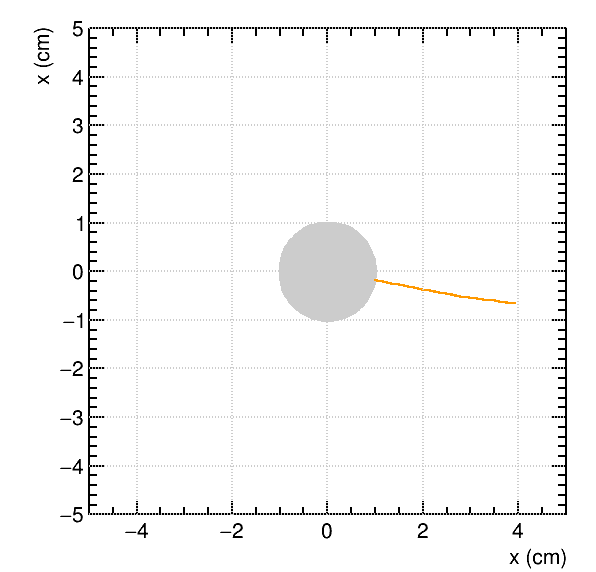

In [14]:
# Plot the geometry and drift line.
cGeom = ROOT.TCanvas("geom", "Geometry")
viewMesh = ROOT.Garfield.ViewFEMesh()
viewMesh.SetArea(-axis_x, -axis_z, -axis_y, axis_x, axis_z, axis_y)
viewMesh.SetCanvas(cGeom)
viewMesh.SetComponent(elm)
viewMesh.SetPlane(0, 0, 1, 0, 0, 0)
viewMesh.SetFillMesh(False)
viewMesh.SetColor(1,ROOT.kGray)
viewMesh.EnableAxes()
viewMesh.SetXaxisTitle("x (cm)")
viewMesh.SetYaxisTitle("x (cm)")
viewMesh.SetViewDrift(viewDrift)
viewMesh.Plot()
cGeom.Draw()

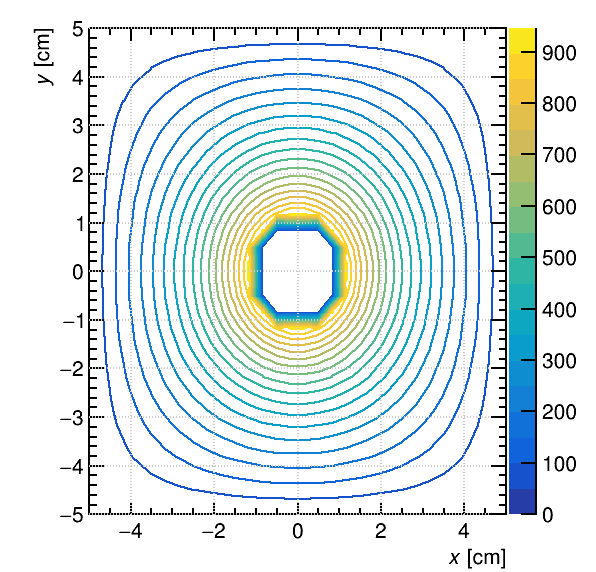

In [15]:
# Plot the fields.
cFields = ROOT.TCanvas("fields", "Fields")
viewField = ROOT.Garfield.ViewField()
viewField.SetSensor(sensor)
viewField.SetCanvas(cFields)
viewField.SetArea(-axis_x, -axis_y, axis_x, axis_y)
viewField.SetNumberOfContours(20)
viewField.SetNumberOfSamples2d(30, 30)
viewField.SetPlane(0, 0, 1, 0, 0, 0)
viewField.PlotContour("v")
cFields.Draw()

# **2. 3D LEM example**

## Create the FEM map

### Create the geometry file

In [16]:
gemcell_geo_text = """//
// Parameters
r0 = 0.015;     // the hole radius
r1 = 0.01;     // the etching amount (etch radius = r0 + r1)
tC = 0.0035;     // copper thickness
tD = 0.04;     // dielectric thickness
lE = 0.5;     // distance from GEM plates to upper exterior electrode
lP = 0.2;     // distance from lower LEM plate to pad (readout) plane
a = 0.07;     // the "pitch", or distance between GEM holes

// Characteristic lengths
lcDielectricHole = 0.0025;
lcEtchingHole = 0.0025;
lcCopperPlateBdry = 0.005;
lcExtElectrodeBdry = 0.03;
lcGEMHole = 0.005;

// ------------------------------------------------------------
// Hole 1 (quarter hole)
// ------------------------------------------------------------

// *******************************
// Center
// *******************************
pc1_1 = newp; Point(pc1_1) = {0, 0, tD/2,lcGEMHole};
pc2_1 = newp; Point(pc2_1) = {0, 0, -1*tD/2,lcGEMHole};
pc3_1 = newp; Point(pc3_1) = {0, 0, (2*tC+tD)/2,lcGEMHole};
pc4_1 = newp; Point(pc4_1) = {0, 0, -1*(2*tC+tD)/2,lcGEMHole};


// *******************************
// Dielectric hole
// *******************************
// Top
pth1_1 = newp; Point(pth1_1) = {r0, 0, tD/2,lcDielectricHole};
pth2_1 = newp; Point(pth2_1) = {0, r0, tD/2,lcDielectricHole};
cth1_1 = 200; Circle(cth1_1) = {pth2_1, pc1_1, pth1_1};

// Bottom
pbh1_1 = newp; Point(pbh1_1) = {r0, 0, -1*tD/2,lcDielectricHole};
pbh2_1 = newp; Point(pbh2_1) = {0, r0, -1*tD/2,lcDielectricHole};
cbh1_1 = newc; Circle(cbh1_1) = {pbh2_1, pc2_1, pbh1_1};


// *******************************
// Upper Etching
// *******************************

// Top
ptue1_1 = newp; Point(ptue1_1) = {(r0+r1), 0, (2*tC+tD)/2,lcEtchingHole};
ptue2_1 = newp; Point(ptue2_1) = {0, (r0+r1), (2*tC+tD)/2,lcEtchingHole};

// Bottom
pbue1_1 = newp; Point(pbue1_1) = {(r0+r1), 0, tD/2,lcEtchingHole};
pbue2_1 = newp; Point(pbue2_1) = {0,(r0+r1), tD/2,lcEtchingHole};

// Circular boundary
ctue1_1 = newc; Circle(ctue1_1) = {ptue2_1, pc3_1, ptue1_1};
cbue1_1 = newc; Circle(cbue1_1) = {pbue2_1, pc1_1, pbue1_1};

// *******************************
// Lower Etching
// *******************************

// Top
ptle1_1 = newp; Point(ptle1_1) = {(r0+r1), 0, -1*tD/2,lcEtchingHole};
ptle2_1 = newp; Point(ptle2_1) = {0, (r0+r1), -1*tD/2,lcEtchingHole};

// Bottom
pble1_1 = newp; Point(pble1_1) = {(r0+r1), 0, -1*(2*tC+tD)/2,lcEtchingHole};
pble2_1 = newp; Point(pble2_1) = {0, (r0+r1), -1*(2*tC+tD)/2,lcEtchingHole};

// Circular boundaries
ctle1_1 = newc; Circle(ctle1_1) = {ptle2_1, pc2_1, ptle1_1};
cble1_1 = newc; Circle(cble1_1) = {pble2_1, pc4_1, pble1_1};

// Lines connecting top and bottom
lconn1_1 = newc; Line(lconn1_1) = {pbh1_1, pth1_1};
lconn2_1 = newc; Line(lconn2_1) = {pbh2_1, pth2_1};
lconn3_1 = newc; Line(lconn3_1) = {pbue2_1, ptle2_1};
lconn4_1 = newc; Line(lconn4_1) = {pbue1_1, ptle1_1};

// ------------------------------------------------------------
// Hole 2 (half hole)
// ------------------------------------------------------------

// *******************************
// Center
// *******************************
pc1_2 = newp; Point(pc1_2) = {a/2, a*Sqrt(3)/2, tD/2,lcGEMHole};
pc2_2 = newp; Point(pc2_2) = {a/2, a*Sqrt(3)/2, -1*tD/2,lcGEMHole};
pc3_2 = newp; Point(pc3_2) = {a/2, a*Sqrt(3)/2, (2*tC+tD)/2,lcGEMHole};
pc4_2 = newp; Point(pc4_2) = {a/2, a*Sqrt(3)/2, -1*(2*tC+tD)/2,lcGEMHole};


// *******************************
// Dielectric hole
// *******************************
// Top
pth1_2 = newp; Point(pth1_2) = {a/2-1*r0, a*Sqrt(3)/2, tD/2,lcDielectricHole};
pth2_2 = newp; Point(pth2_2) = {a/2+r0, a*Sqrt(3)/2, tD/2,lcDielectricHole};
pth3_2 = newp; Point(pth3_2) = {a/2, a*Sqrt(3)/2-1*r0, tD/2,lcDielectricHole};
cth1_2 = newc; Circle(cth1_2) = {pth1_2, pc1_2, pth3_2};
cth2_2 = newc; Circle(cth2_2) = {pth3_2, pc1_2, pth2_2};

// Bottom
pbh1_2 = newp; Point(pbh1_2) = {a/2-1*r0, a*Sqrt(3)/2, -1*tD/2,lcDielectricHole};
pbh2_2 = newp; Point(pbh2_2) = {a/2+r0, a*Sqrt(3)/2, -1*tD/2,lcDielectricHole};
pbh3_2 = newp; Point(pbh3_2) = {a/2, a*Sqrt(3)/2-1*r0, -1*tD/2,lcDielectricHole};
cbh1_2 = newc; Circle(cbh1_2) = {pbh1_2, pc2_2, pbh3_2};
cbh2_2 = newc; Circle(cbh2_2) = {pbh3_2, pc2_2, pbh2_2};

// *******************************
// Upper Etching
// *******************************

// Top
ptue1_2 = newp; Point(ptue1_2) = {a/2-1*(r0+r1), a*Sqrt(3)/2, (2*tC+tD)/2,lcEtchingHole};
ptue2_2 = newp; Point(ptue2_2) = {a/2+(r0+r1), a*Sqrt(3)/2, (2*tC+tD)/2,lcEtchingHole};
ptue3_2 = newp; Point(ptue3_2) = {a/2, a*Sqrt(3)/2-1*(r0+r1), (2*tC+tD)/2,lcEtchingHole};

// Bottom
pbue1_2 = newp; Point(pbue1_2) = {a/2-1*(r0+r1), a*Sqrt(3)/2, tD/2,lcEtchingHole};
pbue2_2 = newp; Point(pbue2_2) = {a/2+(r0+r1), a*Sqrt(3)/2, tD/2,lcEtchingHole};
pbue3_2 = newp; Point(pbue3_2) = {a/2,a*Sqrt(3)/2-1*(r0+r1), tD/2,lcEtchingHole};

// Circular boundary
ctue1_2 = newc; Circle(ctue1_2) = {ptue1_2, pc3_2, ptue3_2};
ctue2_2 = newc; Circle(ctue2_2) = {ptue3_2, pc3_2, ptue2_2};
cbue1_2 = newc; Circle(cbue1_2) = {pbue1_2, pc1_2, pbue3_2};
cbue2_2 = newc; Circle(cbue2_2) = {pbue3_2, pc1_2, pbue2_2};

lue1_2 = newc; Line(lue1_2) = {ptue1_2, pbue1_2};
lue2_2 = newc; Line(lue2_2) = {ptue2_2, pbue2_2};
lue3_2 = newc; Line(lue3_2) = {ptue3_2, pbue3_2};


// *******************************
// Lower Etching
// *******************************

// Top
ptle1_2 = newp; Point(ptle1_2) = {a/2-1*(r0+r1), a*Sqrt(3)/2, -1*tD/2,lcEtchingHole};
ptle2_2 = newp; Point(ptle2_2) = {a/2+(r0+r1), a*Sqrt(3)/2, -1*tD/2,lcEtchingHole};
ptle3_2 = newp; Point(ptle3_2) = {a/2, a*Sqrt(3)/2-1*(r0+r1), -1*tD/2,lcEtchingHole};

// Bottom
pble1_2 = newp; Point(pble1_2) = {a/2-1*(r0+r1), a*Sqrt(3)/2, -1*(2*tC+tD)/2,lcEtchingHole};
pble2_2 = newp; Point(pble2_2) = {a/2+(r0+r1), a*Sqrt(3)/2, -1*(2*tC+tD)/2,lcEtchingHole};
pble3_2 = newp; Point(pble3_2) = {a/2, a*Sqrt(3)/2-1*(r0+r1), -1*(2*tC+tD)/2,lcEtchingHole};

// Circular boundaries
ctle1_2 = newc; Circle(ctle1_2) = {ptle1_2, pc2_2, ptle3_2};
ctle2_2 = newc; Circle(ctle2_2) = {ptle3_2, pc2_2, ptle2_2};
cble1_2 = newc; Circle(cble1_2) = {pble1_2, pc4_2, pble3_2};
cble2_2 = newc; Circle(cble2_2) = {pble3_2, pc4_2, pble2_2};

lle1_2 = newc; Line(lle1_2) = {ptle1_2, pble1_2};
lle2_2 = newc; Line(lle2_2) = {ptle2_2, pble2_2};
lle3_2 = newc; Line(lle3_2) = {ptle3_2, pble3_2};

// Lines connecting top and bottom
lconn1_2 = newc; Line(lconn1_2) = {pbh1_2, pth1_2};
lconn2_2 = newc; Line(lconn2_2) = {pbh2_2, pth2_2};
lconn3_2 = newc; Line(lconn3_2) = {pbh3_2, pth3_2};
lconn4_2 = newc; Line(lconn4_2) = {ptle1_2, pbue1_2};
lconn5_2 = newc; Line(lconn5_2) = {ptle2_2, pbue2_2};
lconn6_2 = newc; Line(lconn6_2) = {pbue3_2, ptle3_2};

// ------------------------------------------------------------
// Hole 3 (quarter hole)
// ------------------------------------------------------------

// *******************************
// Center
// *******************************
pc1_3 = newp; Point(pc1_3) = {a, 0, tD/2,lcGEMHole};
pc2_3 = newp; Point(pc2_3) = {a, 0, -1*tD/2,lcGEMHole};
pc3_3 = newp; Point(pc3_3) = {a, 0, (2*tC+tD)/2,lcGEMHole};
pc4_3 = newp; Point(pc4_3) = {a, 0, -1*(2*tC+tD)/2,lcGEMHole};


// *******************************
// Dielectric hole
// *******************************
// Top
pth1_3 = newp; Point(pth1_3) = {a-r0, 0, tD/2,lcDielectricHole};
pth2_3 = newp; Point(pth2_3) = {a, r0, tD/2,lcDielectricHole};
cth1_3 = newc; Circle(cth1_3) = {pth2_3, pc1_3, pth1_3};

// Bottom
pbh1_3 = newp; Point(pbh1_3) = {a-r0, 0, -1*tD/2,lcDielectricHole};
pbh2_3 = newp; Point(pbh2_3) = {a, r0, -1*tD/2,lcDielectricHole};
cbh1_3 = newc; Circle(cbh1_3) = {pbh2_3, pc2_3, pbh1_3};

// *******************************
// Upper Etching
// *******************************

// Top
ptue1_3 = newp; Point(ptue1_3) = {a-(r0+r1), 0, (2*tC+tD)/2,lcEtchingHole};
ptue2_3 = newp; Point(ptue2_3) = {a, (r0+r1), (2*tC+tD)/2,lcEtchingHole};

// Bottom
pbue1_3 = newp; Point(pbue1_3) = {a-(r0+r1), 0, tD/2,lcEtchingHole};
pbue2_3 = newp; Point(pbue2_3) = {a,(r0+r1), tD/2,lcEtchingHole};

// Circular boundary
ctue1_3 = newc; Circle(ctue1_3) = {ptue2_3, pc3_3, ptue1_3};
cbue1_3 = newc; Circle(cbue1_3) = {pbue2_3, pc1_3, pbue1_3};

// *******************************
// Lower Etching
// *******************************

// Top
ptle1_3 = newp; Point(ptle1_3) = {a-(r0+r1), 0, -1*tD/2,lcEtchingHole};
ptle2_3 = newp; Point(ptle2_3) = {a, (r0+r1), -1*tD/2,lcEtchingHole};

// Bottom
pble1_3 = newp; Point(pble1_3) = {a-(r0+r1), 0, -1*(2*tC+tD)/2,lcEtchingHole};
pble2_3 = newp; Point(pble2_3) = {a, (r0+r1), -1*(2*tC+tD)/2,lcEtchingHole};

// Circular boundaries
ctle1_3 = newc; Circle(ctle1_3) = {ptle2_3, pc2_3, ptle1_3};
cble1_3 = newc; Circle(cble1_3) = {pble2_3, pc4_3, pble1_3};

// Lines connecting top and bottom
lconn1_3 = newc; Line(lconn1_3) = {pbh1_3, pth1_3};
lconn2_3 = newc; Line(lconn2_3) = {pbh2_3, pth2_3};
lconn3_3 = newc; Line(lconn3_3) = {pbue1_3, ptle1_3};
lconn4_3 = newc; Line(lconn4_3) = {pbue2_3, ptle2_3};

// --------------------------------------------------------------------------


// *******************************************************
// Copper planes
// *******************************************************

// Points between two half holes on upper LEM
ptmc = newp; Point(ptmc) = {a/2, 0, (2*tC+tD)/2, lcCopperPlateBdry};
ptmd = newp; Point(ptmd) = {a/2, 0, tD/2, lcCopperPlateBdry};

// Top lower boundary
pcptl1 = newp; Point(pcptl1) = {0, 0, tD/2,lcCopperPlateBdry};
pcptl2 = newp; Point(pcptl2) = {a, a*Sqrt(3)/2, tD/2,lcCopperPlateBdry};
pcptl3 = newp; Point(pcptl3) = {0, a*Sqrt(3)/2, tD/2,lcCopperPlateBdry};

// Top upper boundary
pcptu2 = newp; Point(pcptu2) = {a, a*Sqrt(3)/2, (tD+2*tC)/2,lcCopperPlateBdry};
pcptu3 = newp; Point(pcptu3) = {0, a*Sqrt(3)/2, (tD+2*tC)/2,lcCopperPlateBdry};

// Border lines
// Upper boundary
lcpt1 = newc; Line(lcpt1) = {ptue1_2,pcptu3};
lcpt2 = newc; Line(lcpt2) = {pcptu3,ptue2_1};
lcpt3a = newc; Line(lcpt3a) = {ptue1_1,ptmc};
lcpt3b = newc; Line(lcpt3b) = {ptmc,ptue1_3};
lcpt4 = newc; Line(lcpt4) = {ptue2_3,pcptu2};
lcpt5 = newc; Line(lcpt5) = {pcptu2,ptue2_2};

// Lower boundary
lcpt6 = newc; Line(lcpt6) = {pc1_1,pth2_1};  // starts at point 1 and goes CW holes 1,2,then 3
lcpt7 = newc; Line(lcpt7) = {pth2_1,pbue2_1};
lcpt8 = newc; Line(lcpt8) = {pbue2_1,pcptl3};
lcpt9 = newc; Line(lcpt9) = {pcptl3,pbue1_2};
lcpt10 = newc; Line(lcpt10) = {pbue1_2,pth1_2};
lcpt11a = newc; Line(lcpt11a) = {pth1_2,pc1_2};
lcpt11b = newc; Line(lcpt11b) = {pc1_2,pth2_2};
lcpt12 = newc; Line(lcpt12) = {pth2_2,pbue2_2};
lcpt13 = newc; Line(lcpt13) = {pbue2_2,pcptl2};
lcpt14 = newc; Line(lcpt14) = {pcptl2,pbue2_3};
lcpt15 = newc; Line(lcpt15) = {pbue2_3,pth2_3};
lcpt16 = newc; Line(lcpt16) = {pth2_3,pc1_3};
lcpt17 = newc; Line(lcpt17) = {pc1_3,pth1_3};
lcpt18 = newc; Line(lcpt18) = {pth1_3,pbue1_3};
lcpt19a = newc; Line(lcpt19a) = {pbue1_3,ptmd};
lcpt19b = newc; Line(lcpt19b) = {ptmd,pbue1_1};
lcpt20 = newc; Line(lcpt20) = {pbue1_1,pth1_1};
lcpt21 = newc; Line(lcpt21) = {pth1_1,pc1_1};

// Connect the upper and lower points with lines to form the plate
lcpt22 = newc; Line(lcpt22) = {pcptu2, pcptl2};
lcpt23 = newc; Line(lcpt23) = {pcptu3, pcptl3};
lcpt24 = newc; Line(lcpt24) = {pc3_1, pc1_1};
lcpt25 = newc; Line(lcpt25) = {pc3_3, pc1_3};
lcpt26 = newc; Line(lcpt26) = {ptue2_3, pbue2_3};
lcpt27 = newc; Line(lcpt27) = {ptue1_3, pbue1_3};
lcpt28 = newc; Line(lcpt28) = {ptue1_1, pbue1_1};
lcpt29 = newc; Line(lcpt29) = {ptue2_1, pbue2_1};

// ---------------------------------------------

// Points between two half holes on lower LEM
pbmd = newp; Point(pbmd) = {a/2, 0, -1*tD/2, lcCopperPlateBdry};
pbmc = newp; Point(pbmc) = {a/2, 0, -1*(2*tC+tD)/2, lcCopperPlateBdry};

// Bottom lower boundary
pcpbl2 = newp; Point(pcpbl2) = {a, a*Sqrt(3)/2, -1*(tD+2*tC)/2,lcCopperPlateBdry};
pcpbl3 = newp; Point(pcpbl3) = {0, a*Sqrt(3)/2, -1*(tD+2*tC)/2,lcCopperPlateBdry};

// Bottom upper boundary
pcpbu2 = newp; Point(pcpbu2) = {a, a*Sqrt(3)/2, -1*tD/2,lcCopperPlateBdry};
pcpbu3 = newp; Point(pcpbu3) = {0, a*Sqrt(3)/2, -1*tD/2,lcCopperPlateBdry};

// Border lines
// Upper boundary
lcpb1 = newc; Line(lcpb1) = {pble1_2,pcpbl3};
lcpb2 = newc; Line(lcpb2) = {pcpbl3,pble2_1};
lcpb3a = newc; Line(lcpb3a) = {pble1_1,pbmc};
lcpb3b = newc; Line(lcpb3b) = {pbmc,pble1_3};
lcpb4 = newc; Line(lcpb4) = {pble2_3,pcpbl2};
lcpb5 = newc; Line(lcpb5) = {pcpbl2,pble2_2};

// Lower boundary
lcpb6 = newc; Line(lcpb6) = {pc2_1,pbh2_1};  // starts at point 1 and goes CW holes 1,2,then 3
lcpb7 = newc; Line(lcpb7) = {pbh2_1,ptle2_1};
lcpb8 = newc; Line(lcpb8) = {ptle2_1,pcpbu3};
lcpb9 = newc; Line(lcpb9) = {pcpbu3,ptle1_2};
lcpb10 = newc; Line(lcpb10) = {ptle1_2,pbh1_2};
lcpb11a = newc; Line(lcpb11a) = {pbh1_2,pc2_2};
lcpb11b = newc; Line(lcpb11b) = {pc2_2,pbh2_2};
lcpb12 = newc; Line(lcpb12) = {pbh2_2,ptle2_2};
lcpb13 = newc; Line(lcpb13) = {ptle2_2,pcpbu2};
lcpb14 = newc; Line(lcpb14) = {pcpbu2,ptle2_3};
lcpb15 = newc; Line(lcpb15) = {ptle2_3,pbh2_3};
lcpb16 = newc; Line(lcpb16) = {pbh2_3,pc2_3};
lcpb17 = newc; Line(lcpb17) = {pc2_3,pbh1_3};
lcpb18 = newc; Line(lcpb18) = {pbh1_3,ptle1_3};
lcpb19a = newc; Line(lcpb19a) = {ptle1_3,pbmd};
lcpb19b = newc; Line(lcpb19b) = {pbmd,ptle1_1};
lcpb20 = newc; Line(lcpb20) = {ptle1_1,pbh1_1};
lcpb21 = newc; Line(lcpb21) = {pbh1_1,pc2_1};

// Connect the upper and lower points with lines to form the plate
lcpb22 = newc; Line(lcpb22) = {pcpbu2, pcpbl2};
lcpb23 = newc; Line(lcpb23) = {pcpbu3, pcpbl3};
lcpb24 = newc; Line(lcpb24) = {pc2_1, pc4_1};
lcpb25 = newc; Line(lcpb25) = {pc2_3, pc4_3};
lcpb26 = newc; Line(lcpb26) = {ptle2_3, pble2_3};
lcpb27 = newc; Line(lcpb27) = {ptle1_3, pble1_3};
lcpb28 = newc; Line(lcpb28) = {ptle1_1, pble1_1};
lcpb29 = newc; Line(lcpb29) = {ptle2_1, pble2_1};

lcpb30 = newc; Line(lcpb30) = {pc1_1, pc2_1};
lcpb31 = newc; Line(lcpb31) = {pcptl2, pcpbu2};
lcpb32 = newc; Line(lcpb32) = {pcptl3, pcpbu3};
lcpb33 = newc; Line(lcpb33) = {pc1_3, pc2_3};

// Lines splitting the LEM in half: half hole side
lshalf1 = newc; Line(lshalf1) = {pc3_2, pc1_2};
lshalf2 = newc; Line(lshalf2) = {pc1_2, pc2_2};
lshalf3 = newc; Line(lshalf3) = {pc2_2, pc4_2};

// Lines splitting the LEM in half: quarter hole side
lsqt1 = newc; Line(lsqt1) = {ptmc, ptmd};
lsqt2 = newc; Line(lsqt2) = {ptmd, pbmd};
lsqt3 = newc; Line(lsqt3) = {pbmd, pbmc};

// **********************************************
// External Electrodes
// **********************************************

// Top electrode
pexet1 = newp; Point(pexet1) = {a, a*Sqrt(3)/2, (tD+2*tC)/2+lE,lcExtElectrodeBdry};
pexet2 = newp; Point(pexet2) = {a/2, a*Sqrt(3)/2, (tD+2*tC)/2+lE,lcExtElectrodeBdry};
pexet3 = newp; Point(pexet3) = {0, a*Sqrt(3)/2, (tD+2*tC)/2+lE,lcExtElectrodeBdry};
pexet4 = newp; Point(pexet4) = {0, 0, (tD+2*tC)/2+lE,lcExtElectrodeBdry};
pexet5 = newp; Point(pexet5) = {a/2, 0, (tD+2*tC)/2+lE,lcExtElectrodeBdry};
pexet6 = newp; Point(pexet6) = {a, 0, (tD+2*tC)/2+lE,lcExtElectrodeBdry};

// Top electrode lines
lexet1 = newc; Line(lexet1) = {pexet1, pexet2};
lexet2 = newc; Line(lexet2) = {pexet2, pexet3};
lexet3 = newc; Line(lexet3) = {pexet3, pexet4};
lexet4 = newc; Line(lexet4) = {pexet4, pexet5};
lexet5 = newc; Line(lexet5) = {pexet5, pexet6};
lexet6 = newc; Line(lexet6) = {pexet6, pexet1};

// Connect the top electrode to the LEM.
lexetc1 = newc; Line(lexetc1) = {pexet1, pcptu2};
lexetc2 = newc; Line(lexetc2) = {pexet2, pc3_2};
lexetc3 = newc; Line(lexetc3) = {pexet3, pcptu3};
lexetc4 = newc; Line(lexetc4) = {pexet4, pc3_1};
lexetc5 = newc; Line(lexetc5) = {pexet5, ptmc};
lexetc6 = newc; Line(lexetc6) = {pexet6, pc3_3};

// Bottom electrode
pexeb1 = newp; Point(pexeb1) = {a, a*Sqrt(3)/2, -1*(tD+2*tC)/2-lP,lcExtElectrodeBdry};
pexeb2 = newp; Point(pexeb2) = {a/2, a*Sqrt(3)/2, -1*(tD+2*tC)/2-lP,lcExtElectrodeBdry};
pexeb3 = newp; Point(pexeb3) = {0, a*Sqrt(3)/2, -1*(tD+2*tC)/2-lP,lcExtElectrodeBdry};
pexeb4 = newp; Point(pexeb4) = {0, 0, -1*(tD+2*tC)/2-lP,lcExtElectrodeBdry};
pexeb5 = newp; Point(pexeb5) = {a/2, 0, -1*(tD+2*tC)/2-lP,lcExtElectrodeBdry};
pexeb6 = newp; Point(pexeb6) = {a, 0, -1*(tD+2*tC)/2-lP,lcExtElectrodeBdry};

// Bottom electrode lines
lexeb1 = newc; Line(lexeb1) = {pexeb1, pexeb2};
lexeb2 = newc; Line(lexeb2) = {pexeb2, pexeb3};
lexeb3 = newc; Line(lexeb3) = {pexeb3, pexeb4};
lexeb4 = newc; Line(lexeb4) = {pexeb4, pexeb5};
lexeb5 = newc; Line(lexeb5) = {pexeb5, pexeb6};
lexeb6 = newc; Line(lexeb6) = {pexeb6, pexeb1};

// Connect the bottom electrode to the LEM.
lexebc1 = newc; Line(lexebc1) = {pexeb1, pcpbl2};
lexebc2 = newc; Line(lexebc2) = {pexeb2, pc4_2};
lexebc3 = newc; Line(lexebc3) = {pexeb3, pcpbl3};
lexebc4 = newc; Line(lexebc4) = {pexeb4, pc4_1};
lexebc5 = newc; Line(lexebc5) = {pexeb5, pbmc};
lexebc6 = newc; Line(lexebc6) = {pexeb6, pc4_3};

// *************************************************
// Define surfaces
// *************************************************

// Copper plate surfaces
llcp_up_rim1_2 = newreg; Line Loop(llcp_up_rim1_2) = {-lue1_2, -cbue1_2, lue3_2, ctue1_2};
rscp_up_rim1_2 = newreg; Ruled Surface(rscp_up_rim1_2) = {llcp_up_rim1_2};
llcp_up_rim2_2 = newreg; Line Loop(llcp_up_rim2_2) = {lue2_2, -1*cbue2_2, -1*lue3_2, ctue2_2};
rscp_up_rim2_2 = newreg; Ruled Surface(rscp_up_rim2_2) = {llcp_up_rim2_2};

llcp_up_rim_1 = newreg; Line Loop(llcp_up_rim_1) = {lcpt29, cbue1_1, -lcpt28, -ctue1_1};
rscp_up_rim_1 = newreg; Ruled Surface(rscp_up_rim_1) = {llcp_up_rim_1};
llcp_up_rim_3 = newreg; Line Loop(llcp_up_rim_3) = {lcpt27, -cbue1_3, -lcpt26, ctue1_3};
rscp_up_rim_3 = newreg; Ruled Surface(rscp_up_rim_3) = {llcp_up_rim_3};

llcp_up_border1 = newreg; Line Loop(llcp_up_border1) = {lcpt26, -lcpt14, -lcpt22, -lcpt4};
pscp_up_border1 = newreg; Plane Surface(pscp_up_border1) = {llcp_up_border1};
llcp_up_border2 = newreg; Line Loop(llcp_up_border2) = {lue1_2, -lcpt9, -lcpt23, -lcpt1};
pscp_up_border2 = newreg; Plane Surface(pscp_up_border2) = {llcp_up_border2};
llcp_up_border3 = newreg; Line Loop(llcp_up_border3) = {-lcpt2, -lcpt29, -lcpt8, lcpt23};
pscp_up_border3 = newreg; Plane Surface(pscp_up_border3) = {llcp_up_border3};
llcp_up_border4a = newreg; Line Loop(llcp_up_border4a) = {-lcpt3b, -lcpt27, -lcpt19a, lsqt1};
pscp_up_border4a = newreg; Plane Surface(pscp_up_border4a) = {llcp_up_border4a};
llcp_up_border4b = newreg; Line Loop(llcp_up_border4b) = {-lcpt3a, lcpt28, -lcpt19b, -lsqt1};
pscp_up_border4b = newreg; Plane Surface(pscp_up_border4b) = {llcp_up_border4b};
llcp_up_border5 = newreg; Line Loop(llcp_up_border5) = {-lcpt5, -lue2_2, -lcpt13, lcpt22};
pscp_up_border5 = newreg; Plane Surface(pscp_up_border5) = {llcp_up_border5};

llcp_low_rim1_2 = newreg; Line Loop(llcp_low_rim1_2) = {-lle1_2, ctle1_2, lle3_2, -cble1_2};
rscp_low_rim1_2 = newreg; Ruled Surface(rscp_low_rim1_2) = {llcp_low_rim1_2};
llcp_low_rim2_2 = newreg; Line Loop(llcp_low_rim2_2) = {lle2_2, ctle2_2, -lle3_2, -cble2_2};
rscp_low_rim2_2 = newreg; Ruled Surface(rscp_low_rim2_2) = {llcp_low_rim2_2};

llcp_low_rim_1 = newreg; Line Loop(llcp_low_rim_1) = {lcpb29, -ctle1_1, -lcpb28, cble1_1};
rscp_low_rim_1 = newreg; Ruled Surface(rscp_low_rim_1) = {llcp_low_rim_1};
llcp_low_rim_3 = newreg; Line Loop(llcp_low_rim_3) = {lcpb27, ctle1_3, -lcpb26, -cble1_3};
rscp_low_rim_3 = newreg; Ruled Surface(rscp_low_rim_3) = {llcp_low_rim_3};

llcp_low_border1 = newreg; Line Loop(llcp_low_border1) = {lcpb26, lcpb14, -lcpb22, lcpb4};
pscp_low_border1 = newreg; Plane Surface(pscp_low_border1) = {llcp_low_border1};
llcp_low_border2 = newreg; Line Loop(llcp_low_border2) = {lle1_2, lcpb9, -lcpb23, lcpb1};
pscp_low_border2 = newreg; Plane Surface(pscp_low_border2) = {llcp_low_border2};
llcp_low_border3 = newreg; Line Loop(llcp_low_border3) = {lcpb2, -lcpb29, lcpb8, lcpb23};
pscp_low_border3 = newreg; Plane Surface(pscp_low_border3) = {llcp_low_border3};
llcp_low_border4a = newreg; Line Loop(llcp_low_border4a) = {lcpb19a, lsqt3, lcpb3b, -lcpb27};
pscp_low_border4a = newreg; Plane Surface(pscp_low_border4a) = {llcp_low_border4a};
llcp_low_border4b = newreg; Line Loop(llcp_low_border4b) = {lcpb19b, lcpb28, lcpb3a, -lsqt3};
pscp_low_border4b = newreg; Plane Surface(pscp_low_border4b) = {llcp_low_border4b};
llcp_low_border5 = newreg; Line Loop(llcp_low_border5) = {lcpb5, -lle2_2, lcpb13, lcpb22};
pscp_low_border5 = newreg; Plane Surface(pscp_low_border5) = {llcp_low_border5};

llcp_face1 = newreg; Line Loop(llcp_face1) = {lcpt2, ctue1_1, lcpt3a, lcpt3b, -1*ctue1_3, lcpt4, lcpt5, -1*ctue2_2, -1*ctue1_2, lcpt1};
pscp_face1 = newreg; Plane Surface(pscp_face1) = {llcp_face1};
llcp_face2 = newreg; Line Loop(llcp_face2) = {-lcpb1, -lcpb2, -cble1_1, -lcpb3a, -lcpb3b, cble1_3, -lcpb4, -lcpb5, cble2_2, cble1_2};
pscp_face2 = newreg; Plane Surface(pscp_face2) = {llcp_face2};

// Dielectric surfaces
ll_up_dielectric_1 = newreg; Line Loop(ll_up_dielectric_1) = {-lcpt7, -cbue1_1, -lcpt20, cth1_1};
ps_up_dielectric_1 = newreg; Plane Surface(ps_up_dielectric_1) = {ll_up_dielectric_1};
ll_low_dielectric_1 = newreg; Line Loop(ll_low_dielectric_1) = {lcpb7, ctle1_1, lcpb20, -cbh1_1};
ps_low_dielectric_1 = newreg; Plane Surface(ps_low_dielectric_1) = {ll_low_dielectric_1};

ll_up_dielectric_2 = newreg; Line Loop(ll_up_dielectric_2) = {-lcpt12, cbue2_2, cbue1_2, -lcpt10, -cth1_2, -cth2_2};
ps_up_dielectric_2 = newreg; Plane Surface(ps_up_dielectric_2) = {ll_up_dielectric_2};
ll_low_dielectric_2 = newreg; Line Loop(ll_low_dielectric_2) = {lcpb12, -ctle2_2, -ctle1_2, lcpb10, cbh1_2, cbh2_2};
ps_low_dielectric_2 = newreg; Plane Surface(ps_low_dielectric_2) = {ll_low_dielectric_2};

ll_up_dielectric_3 = newreg; Line Loop(ll_up_dielectric_3) = {-lcpt15, -cth1_3, -lcpt18, cbue1_3};
ps_up_dielectric_3 = newreg; Plane Surface(ps_up_dielectric_3) = {ll_up_dielectric_3};
ll_low_dielectric_3 = newreg; Line Loop(ll_low_dielectric_3) = {lcpb15, cbh1_3, lcpb18, -ctle1_3};
ps_low_dielectric_3 = newreg; Plane Surface(ps_low_dielectric_3) = {ll_low_dielectric_3}; 

ll_cyl_dielectric1_2 = newreg; Line Loop(ll_cyl_dielectric1_2) = {lconn1_2, cth1_2, -lconn3_2, -cbh1_2};
rs_cyl_dielectric1_2 = newreg; Ruled Surface(rs_cyl_dielectric1_2) = {ll_cyl_dielectric1_2};
ll_cyl_dielectric2_2 = newreg; Line Loop(ll_cyl_dielectric2_2) = {cth2_2, -lconn2_2, -cbh2_2, lconn3_2};
rs_cyl_dielectric2_2 = newreg; Ruled Surface(rs_cyl_dielectric2_2) = {ll_cyl_dielectric2_2};

ll_cyl_dielectric3 = newreg; Line Loop(ll_cyl_dielectric3) = {lconn2_3, cth1_3, -lconn1_3, -cbh1_3};
rs_cyl_dielectric3 = newreg; Ruled Surface(rs_cyl_dielectric3) = {ll_cyl_dielectric3};

ll_cyl_dielectric1 = newreg; Line Loop(ll_cyl_dielectric1) = {lconn1_1, -cth1_1, -lconn2_1, cbh1_1};
rs_cyl_dielectric1 = newreg; Ruled Surface(rs_cyl_dielectric1) = {ll_cyl_dielectric1};

ll_side_dielectric1a = newreg; Line Loop(ll_side_dielectric1a) = {-lconn1_1, lcpt20, -lconn4_1, -lcpb20};
ps_side_dielectric1a = newreg; Plane Surface(ps_side_dielectric1a) = {ll_side_dielectric1a};
ll_side_dielectric1b = newreg; Line Loop(ll_side_dielectric1b) = {lconn4_1, lcpt19b, -lsqt2, -lcpb19b};
ps_side_dielectric1b = newreg; Plane Surface(ps_side_dielectric1b) = {ll_side_dielectric1b};
ll_side_dielectric1c = newreg; Line Loop(ll_side_dielectric1c) = {lconn1_3, lcpt18, lconn3_3, -lcpb18};
ps_side_dielectric1c = newreg; Plane Surface(ps_side_dielectric1c) = {ll_side_dielectric1c};
ll_side_dielectric1d = newreg; Line Loop(ll_side_dielectric1d) = {-lconn3_3, lcpt19a, lsqt2, -lcpb19a};
ps_side_dielectric1d = newreg; Plane Surface(ps_side_dielectric1d) = {ll_side_dielectric1d};
ll_side_dielectric2a = newreg; Line Loop(ll_side_dielectric2a) = {lcpt14, -lcpb31, -lcpb14, lconn4_3};
ps_side_dielectric2a = newreg; Plane Surface(ps_side_dielectric2a) = {ll_side_dielectric2a};
ll_side_dielectric2b = newreg; Line Loop(ll_side_dielectric2b) = {-lconn2_3, lcpt15, -lconn4_3, -lcpb15};
ps_side_dielectric2b = newreg; Plane Surface(ps_side_dielectric2b) = {ll_side_dielectric2b};
ll_side_dielectric3a = newreg; Line Loop(ll_side_dielectric3a) = {lcpt13, lcpb31, -lcpb13, lconn5_2};
ps_side_dielectric3a = newreg; Plane Surface(ps_side_dielectric3a) = {ll_side_dielectric3a};
ll_side_dielectric3b = newreg; Line Loop(ll_side_dielectric3b) = {-lconn5_2, lcpt12, lconn2_2, -lcpb12};
ps_side_dielectric3b = newreg; Plane Surface(ps_side_dielectric3b) = {ll_side_dielectric3b};
ll_side_dielectric4a = newreg; Line Loop(ll_side_dielectric4a) = {lcpt10, -lconn1_2, -lcpb10, lconn4_2};
ps_side_dielectric4a = newreg; Plane Surface(ps_side_dielectric4a) = {ll_side_dielectric4a};
ll_side_dielectric4b = newreg; Line Loop(ll_side_dielectric4b) = {-lconn4_2, lcpt9, -lcpb32, -lcpb9};
ps_side_dielectric4b = newreg; Plane Surface(ps_side_dielectric4b) = {ll_side_dielectric4b};
ll_side_dielectric5a = newreg; Line Loop(ll_side_dielectric5a) = {lcpt8, lcpb32, -lcpb8, -lconn3_1};
ps_side_dielectric5a = newreg; Plane Surface(ps_side_dielectric5a) = {ll_side_dielectric5a};
ll_side_dielectric5b = newreg; Line Loop(ll_side_dielectric5b) = {lcpt7, lconn3_1, -lcpb7, lconn2_1};
ps_side_dielectric5b = newreg; Plane Surface(ps_side_dielectric5b) = {ll_side_dielectric5b};

ll_top_dielectric = newreg; Line Loop(ll_top_dielectric) = {lcpt9, cbue1_2, cbue2_2, lcpt13, lcpt14, cbue1_3, lcpt19a, lcpt19b, -cbue1_1, lcpt8};
ps_top_dielectric = newreg; Plane Surface(ps_top_dielectric) = {ll_top_dielectric};
ll_bottom_dielectric = newreg; Line Loop(ll_bottom_dielectric) = {-lcpb19a, -lcpb19b, ctle1_1, -lcpb8, -lcpb9, -ctle1_2, -ctle2_2, -lcpb13, -lcpb14, -ctle1_3};
ps_bottom_dielectric = newreg; Plane Surface(ps_bottom_dielectric) = {ll_bottom_dielectric};

// Bounding surfaces
ll_bsurf1 = newreg; Line Loop(ll_bsurf1) = {-lconn1_3, lcpt17, -lcpb33, -lcpb17};
ps_bsurf1 = newreg; Plane Surface(ps_bsurf1) = {ll_bsurf1};
ll_bsurf2 = newreg; Line Loop(ll_bsurf2) = {lcpb33, -lcpb16, lconn2_3, lcpt16};
ps_bsurf2 = newreg; Plane Surface(ps_bsurf2) = {ll_bsurf2};
ll_bsurf3a = newreg; Line Loop(ll_bsurf3a) = {lconn1_2, lcpt11a, lshalf2, -lcpb11a};
ps_bsurf3a = newreg; Plane Surface(ps_bsurf3a) = {ll_bsurf3a};
ll_bsurf3b = newreg; Line Loop(ll_bsurf3b) = {-lconn2_2, lcpt11b, -lshalf2, -lcpb11b};
ps_bsurf3b = newreg; Plane Surface(ps_bsurf3b) = {ll_bsurf3b};
ll_bsurf4 = newreg; Line Loop(ll_bsurf4) = {lcpt6, -lconn2_1, -lcpb6, -lcpb30};
ps_bsurf4 = newreg; Plane Surface(ps_bsurf4) = {ll_bsurf4};
ll_bsurf5 = newreg; Line Loop(ll_bsurf5) = {lcpt21, lcpb30, -lcpb21, lconn1_1};
ps_bsurf5 = newreg; Plane Surface(ps_bsurf5) = {ll_bsurf5};
ll_bsurf6a = newreg; Line Loop(ll_bsurf6a) = {-lexet1, -lexetc2, -lshalf1, -lcpt11b, -lcpt12, lue2_2, lcpt5, lexetc1};
ps_bsurf6a = newreg; Plane Surface(ps_bsurf6a) = {ll_bsurf6a};
ll_bsurf6b = newreg; Line Loop(ll_bsurf6b) = {-lexet2, -lexetc3, lcpt1, -lue1_2, -lcpt10, -lcpt11a, lshalf1, lexetc2};
ps_bsurf6b = newreg; Plane Surface(ps_bsurf6b) = {ll_bsurf6b};
ll_bsurf7a = newreg; Line Loop(ll_bsurf7a) = {-lexet5, -lexetc6, -lcpt25, -lcpt17, -lcpt18, lcpt27, lcpt3b, lexetc5};
ps_bsurf7a = newreg; Plane Surface(ps_bsurf7a) = {ll_bsurf7a};
ll_bsurf7b = newreg; Line Loop(ll_bsurf7b) = {-lexet4, lexetc4, lcpt24, -lcpt21, -lcpt20, -lcpt28, lcpt3a, -lexetc5};
ps_bsurf7b = newreg; Plane Surface(ps_bsurf7b) = {ll_bsurf7b};
ll_bsurf8 = newreg; Line Loop(ll_bsurf8) = {-lexetc4, -lcpt24, -lcpt6, -lcpt7, lcpt29, lcpt2, lexetc3, -lexet3};
ps_bsurf8 = newreg; Plane Surface(ps_bsurf8) = {ll_bsurf8};
ll_bsurf9 = newreg; Line Loop(ll_bsurf9) = {lexet1, lexet2, lexet3, lexet4, lexet5, lexet6};
ps_bsurf9 = newreg; Plane Surface(ps_bsurf9) = {ll_bsurf9};

ll_bsurf10 = newreg; Line Loop(ll_bsurf10) = {-lexebc6, lcpb25, lcpb16, lcpb15, -lcpb26, -lcpb4, lexebc1, lexeb6};
ps_bsurf10 = newreg; Plane Surface(ps_bsurf10) = {ll_bsurf10};
ll_bsurf11a = newreg; Line Loop(ll_bsurf11a) = {-lexebc5, -lcpb3b, lcpb27, lcpb18, lcpb17, -lcpb25, lexebc6, lexeb5};
ps_bsurf11a = newreg; Plane Surface(ps_bsurf11a) = {ll_bsurf11a};
ll_bsurf11b = newreg; Line Loop(ll_bsurf11b) = {lexebc5, -lcpb3a, -lcpb28, lcpb20, lcpb21, lcpb24, -lexebc4, lexeb4};
ps_bsurf11b = newreg; Plane Surface(ps_bsurf11b) = {ll_bsurf11b};
ll_bsurf12 = newreg; Line Loop(ll_bsurf12) = {-lexebc3, -lcpb2, lcpb29, lcpb7, lcpb6, -lcpb24, lexebc4, lexeb3};
ps_bsurf12 = newreg; Plane Surface(ps_bsurf12) = {ll_bsurf12};
ll_bsurf13a = newreg; Line Loop(ll_bsurf13a) = {lexeb1, lexebc2, -lshalf3, lcpb11b, lcpb12, lle2_2, -lcpb5, -lexebc1};
ps_bsurf13a = newreg; Plane Surface(ps_bsurf13a) = {ll_bsurf13a};
ll_bsurf13b = newreg; Line Loop(ll_bsurf13b) = {lexeb2, lexebc3, -lcpb1, -lle1_2, lcpb10, lcpb11a, lshalf3, -lexebc2};
ps_bsurf13b = newreg; Plane Surface(ps_bsurf13b) = {ll_bsurf13b};
ll_bsurf14 = newreg; Line Loop(ll_bsurf14) = {-lexeb1, -lexeb2, -lexeb3, -lexeb4, -lexeb5, -lexeb6};
ps_bsurf14 = newreg; Plane Surface(ps_bsurf14) = {ll_bsurf14};
ll_bsurf15 = newreg; Line Loop(ll_bsurf15) = {lexetc6, lcpt25, -lcpt16, -lcpt15, -lcpt26, lcpt4, -lexetc1, -lexet6};
ps_bsurf15 = newreg; Plane Surface(ps_bsurf15) = {ll_bsurf15};

// Volumes
sl_dielectric = newreg; Surface Loop(sl_dielectric) = {ps_top_dielectric, ps_bottom_dielectric, ps_side_dielectric1a, ps_side_dielectric1b, ps_side_dielectric1c, ps_side_dielectric1d, ps_up_dielectric_1, ps_up_dielectric_3, ps_low_dielectric_1, ps_low_dielectric_3, ps_side_dielectric2a, ps_side_dielectric2b, ps_side_dielectric3a, ps_side_dielectric3b, ps_side_dielectric4a, ps_side_dielectric4b, ps_side_dielectric5a, ps_side_dielectric5b, ps_up_dielectric_2, ps_low_dielectric_2, rs_cyl_dielectric1_2, rs_cyl_dielectric2_2, rs_cyl_dielectric1, rs_cyl_dielectric3};
vol_dielectric = newreg; Volume(vol_dielectric) = {sl_dielectric};

sl_gas = newreg; Surface Loop(sl_gas) = {ps_bsurf9, ps_bsurf6a, ps_bsurf6b, ps_bsurf15, ps_bsurf7a, ps_bsurf7b, ps_bsurf8, ps_bsurf4, ps_bsurf12, ps_bsurf14, ps_bsurf11a, ps_bsurf11b, ps_bsurf5, ps_bsurf1, ps_bsurf2, ps_bsurf10, ps_bsurf13a, ps_bsurf13b, ps_bsurf3a, ps_bsurf3b, -rs_cyl_dielectric1_2, -ps_up_dielectric_2, -rs_cyl_dielectric2_2, -ps_low_dielectric_2, -rscp_low_rim2_2, -rscp_low_rim_1, -rscp_low_rim_3, -rscp_low_rim1_2, -rscp_up_rim2_2, -rscp_up_rim1_2, -pscp_face1, -pscp_face2, -rscp_up_rim_1, -rs_cyl_dielectric3, -ps_up_dielectric_3, -ps_low_dielectric_3, -rscp_up_rim_3, -rs_cyl_dielectric1, -ps_up_dielectric_1, -ps_low_dielectric_1};
vol_gas = newreg; Volume(vol_gas) = {sl_gas};

sl_upper_cp = newreg; Surface Loop(sl_upper_cp) = {pscp_face1, rscp_up_rim_1, rscp_up_rim_3, rscp_up_rim2_2, rscp_up_rim1_2, ps_top_dielectric, pscp_up_border4a, pscp_up_border4b, pscp_up_border3, pscp_up_border2, pscp_up_border5, pscp_up_border1};
vol_upper_cp = newreg; Volume(vol_upper_cp) = {sl_upper_cp};

sl_lower_cp = newreg; Surface Loop(sl_lower_cp) = {pscp_face2, ps_bottom_dielectric, rscp_low_rim_1, rscp_low_rim_3, rscp_low_rim2_2, rscp_low_rim1_2, pscp_low_border3, pscp_low_border2, pscp_low_border4a, pscp_low_border4b, pscp_low_border1, pscp_low_border5};
vol_lower_cp = newreg; Volume(vol_lower_cp) = {sl_lower_cp};

// Physical surfaces

// Surfaces to which voltages will be applied
physsurf_upper_cp = newreg; Physical Surface(physsurf_upper_cp) = {pscp_face1, rscp_up_rim_1, rscp_up_rim_3, rscp_up_rim2_2, rscp_up_rim1_2, ps_top_dielectric, pscp_up_border4a, pscp_up_border4b, pscp_up_border3, pscp_up_border2, pscp_up_border5, pscp_up_border1};
physsurf_lower_cp = newreg; Physical Surface(physsurf_lower_cp) = {pscp_face2, ps_bottom_dielectric, rscp_low_rim_1, rscp_low_rim_3, rscp_low_rim2_2, rscp_low_rim1_2, pscp_low_border3, pscp_low_border2, pscp_low_border4a, pscp_low_border4b, pscp_low_border1, pscp_low_border5};
physsurf_upper_el = newreg; Physical Surface(physsurf_upper_el) = {ps_bsurf9};
physsurf_lower_el = newreg; Physical Surface(physsurf_lower_el) = {ps_bsurf14};

// Surfaces for periodic boundary conditions
physsurf_bd1h1 = newreg; Physical Surface(physsurf_bd1h1) = {ps_bsurf5, ps_bsurf7b, ps_side_dielectric1a, ps_bsurf11b, ps_side_dielectric1b};
physsurf_bd1h2 = newreg; Physical Surface(physsurf_bd1h2) = {ps_side_dielectric3a, ps_side_dielectric3b, ps_bsurf6a, ps_bsurf13a, ps_bsurf3b};

physsurf_bd2h3 = newreg; Physical Surface(physsurf_bd2h3) = {ps_bsurf1, ps_bsurf7a, ps_side_dielectric1c, ps_bsurf11a, ps_side_dielectric1d};
physsurf_bd2h2 = newreg; Physical Surface(physsurf_bd2h2) = {ps_side_dielectric4b, ps_side_dielectric4a, ps_bsurf6b, ps_bsurf13b, ps_bsurf3a};

physsurf_bd3h1 = newreg; Physical Surface(physsurf_bd3h1) = {ps_bsurf8, ps_side_dielectric5a, ps_side_dielectric5b, ps_bsurf4, ps_bsurf12};
physsurf_bd3h3 = newreg; Physical Surface(physsurf_bd3h3) = {ps_bsurf15, ps_side_dielectric2a, ps_side_dielectric2b, ps_bsurf2, ps_bsurf10};

// Physical volumes
physvol_gas = newreg; Physical Volume(physvol_gas) = {vol_gas};
physvol_dielectric = newreg; Physical Volume(physvol_dielectric) = {vol_dielectric};
physvol_upper_cp = newreg; Physical Volume(physvol_upper_cp) = {vol_upper_cp};
physvol_lower_cp = newreg; Physical Volume(physvol_lower_cp) = {vol_lower_cp};
"""

gemcell_geo_file = open("gemcell.geo", "w")
gemcell_geo_file.write(gemcell_geo_text)
gemcell_geo_file.close()

### Create the mesh with gmsh

In [17]:
!gmsh gemcell.geo -3 -order 2

Info    : Running 'gmsh gemcell.geo -3 -order 2' [Gmsh 4.5.6, 1 node, max. 1 thread]
Info    : Started on Wed Mar 10 23:33:21 2021
Info    : Reading 'gemcell.geo'...
Info    : 'gemcell.geo', line 419 : 'Ruled Surface' command is deprecated: use 'Surface' instead
Info    : 'gemcell.geo', line 421 : 'Ruled Surface' command is deprecated: use 'Surface' instead
Info    : 'gemcell.geo', line 424 : 'Ruled Surface' command is deprecated: use 'Surface' instead
Info    : 'gemcell.geo', line 426 : 'Ruled Surface' command is deprecated: use 'Surface' instead
Info    : 'gemcell.geo', line 442 : 'Ruled Surface' command is deprecated: use 'Surface' instead
Info    : 'gemcell.geo', line 444 : 'Ruled Surface' command is deprecated: use 'Surface' instead
Info    : 'gemcell.geo', line 447 : 'Ruled Surface' command is deprecated: use 'Surface' instead
Info    : 'gemcell.geo', line 449 : 'Ruled Surface' command is deprecated: use 'Surface' instead
Info    : 'gemcell.geo', line 486 : 'Ruled Surface' comman

### Convert the mesh to Elmer format

In [18]:
!ElmerGrid 14 2 gemcell.msh -autoclean


Starting program Elmergrid
Elmergrid reading in-line arguments
Lower dimensional boundaries will be removed
Materials and boundaries will be renumbered
Nodes that do not appear in any element will be removed
Output will be saved to file gemcell.

Elmergrid loading data:
-----------------------
Format chosen using the first line: $MeshFormat
Gmsh version is 4.1
Loading mesh in Gmsh format 4.1 from file gemcell.msh
Reading 79 entities in 0D
Reading 142 entities in 1D
Reading 66 entities in 2D
Reading 4 entities in 3D
Allocating for 97849 knots and 79210 elements.
Allocating lookup table for tags of size 481
Maximum original tag for 142 1DIM entities is 341
Maximum original tag for 66 2DIM entities is 473
Maximum original tag for 4 3DIM entities is 481
Reading 97849 nodes in 289 blocks.
Reading 79210 elements in 60 blocks.
Reading 66 elements with tag 343 of type 306
Mapping mesh tag 343 to physical tag 482 in 2DIM
Reading 66 elements with tag 345 of type 306
Mapping mesh tag 345 to phys

### Create the .sif file

In [19]:
gemcell_sif_text = """
Check Keywords Warn

! Set drift distance, E fields, and voltage between GEMs
! dist: distance in cm
! Edrift: drift field in V/cm
! Etrans: transfer field in V/cm
! deltaV: voltage (in V) between GEMs
$ldist = 0.2
$udist = 0.5
$Edrift = 50
$Etrans = 1000
$deltaV = 850

$WTuel = 0
$WTucp = 0
$WTlcp = 0
$WTlel = 0

Header
  Mesh DB "." "gemcell"
End

Simulation
  Coordinate System = Cartesian 3D
  Simulation Type = Steady State
  Steady State Max Iterations = 1
  Output File = "gemcell.result"
  Post File = "gemcell.ep"
End

Constants
  Permittivity Of Vacuum = 8.8542e-12
End

Body 1
  Equation = 1
  Material = 1
End

Body 2
  Equation = 1
  Material = 2
End

Body 3
  Equation = 1
  Material = 3
End

Body 4
  Equation = 1
  Material = 3
End

Equation 1
  Active Solvers(1) = 1
  Calculate Electric Energy = True
End

Solver 1
  Equation = Stat Elec Solver
  Variable = Potential
  Variable DOFs = 1
  Procedure = "StatElecSolve" "StatElecSolver"
  Calculate Electric Field = True
  Calculate Electric Flux = False
  Linear System Solver = Iterative
  Linear System Iterative Method = BiCGStab
  Linear System Max Iterations = 1000
  Linear System Abort Not Converged = True
  Linear System Convergence Tolerance = 1.0e-10
  Linear System Preconditioning = ILU1
  Steady State Convergence Tolerance = 5.0e-7
!  Adaptive Mesh Refinement = True
!  Adaptive Remesh = True
!  Adaptive Save Mesh = True
!  Adaptive Error Limit = 1.0e-12
End

! Gas
Material 1
  Relative Permittivity = 1
  Density = 1
End

! Dielectric
Material 2
  Relative Permittivity = 3.23
  Density = 2
End

! Copper
Material 3
  Relative Permittivity = 1.0e10
  Density = 3
End

! Upper copper plate
Boundary Condition 1
  Target Boundaries = 1
  Potential = $-1*Etrans*ldist - deltaV + WTucp
End

! Lower copper plate
Boundary Condition 2
  Target Boundaries = 2
  Potential = $-1*Etrans*ldist + WTlcp
End

! Upper electrode
Boundary Condition 3
  Target Boundaries = 3
  Potential = $-1*Etrans*ldist - deltaV - Edrift*udist + WTuel
End

! Lower electrode
Boundary Condition 4
  Target Boundaries = 4
  Potential = $WTlel
End

! Set up boundary A for hole 1
Boundary Condition 5
  Target Boundaries = 5
End
! Link to half A of hole 2
Boundary Condition 6
  Target Boundaries = 6
  Periodic BC = 5
  Periodic BC Potential = Logical True
End

! Set up boundary B for hole 3
Boundary Condition 7
  Target Boundaries = 7
End
! Link to half B of hole 2
Boundary Condition 8
  Target Boundaries = 8
  Periodic BC = 7
  Periodic BC Potential = Logical True
End

! Set up boundary C for hole 1 side
Boundary Condition 9
  Target Boundaries = 9
End
! Link to the side containing hole 3
Boundary Condition 10
  Target Boundaries = 10
  Periodic BC = 9
  Periodic BC Potential = Logical True
End
"""

gemcell_sif_file = open("gemcell.sif", "w")
gemcell_sif_file.write(gemcell_sif_text)
gemcell_sif_file.close()

### Solve for the fields with ElmerSolver

In [20]:
!ElmerSolver gemcell.sif

ELMER SOLVER (v 9.0) STARTED AT: 2021/03/10 23:33:27
ParCommInit:  Initialize #PEs:            1
MAIN: 
MAIN: =============================================================
MAIN: ElmerSolver finite element software, Welcome!
MAIN: This program is free software licensed under (L)GPL
MAIN: Copyright 1st April 1995 - , CSC - IT Center for Science Ltd.
MAIN: Webpage http://www.csc.fi/elmer, Email elmeradm@csc.fi
MAIN: Version: 9.0 (Rev: 5b5a9f3a, Compiled: 2021-03-10)
MAIN:  Running one task without MPI parallelization.
MAIN:  Running with just one thread per task.
MAIN: =============================================================
LoadInputFile: Trying to read "Run Control" section only
MAIN: 
MAIN: 
MAIN: -------------------------------------
MAIN: Reading Model: gemcell.sif
LoadInputFile: Scanning input file: gemcell.sif
LoadInputFile: Scanning only size info
LoadInputFile: First time visiting
LoadInputFile: Reading base load of sif file
LoadInputFile: Loading input file: gemcell.sif
Loa

### Create the file dielectrics.dat

In [21]:
gemcell_dielectrics_text = """4
1 1
2 3.23
3 1e10
4 1e10
"""
gemcell_dielectrics_file = open("gemcell/dielectrics.dat", "w")
gemcell_dielectrics_file.write(gemcell_dielectrics_text)
gemcell_dielectrics_file.close()

## Import the field map into Garfield++

### Setup

In [22]:
# Set relevant LEM parameters.
# LEM thickness in cm
lem_th = 0.04;
# copper thickness
lem_cpth = 0.0035;
# LEM pitch in cm
lem_pitch = 0.07;
# X-width of drift simulation will cover between +/- axis_x
axis_x = 0.1;
# Y-width of drift simulation will cover between +/- axis_y
axis_y = 0.1;  
axis_z = 0.25 + lem_th / 2 + lem_cpth;

# Define the medium.
gas = ROOT.Garfield.MediumMagboltz()
gas.SetTemperature(293.15)
gas.SetPressure(740.)
gas.EnableDrift()
gas.SetComposition("ar", 70., "co2", 30.)

True

MediumMagboltz::SetComposition:
    Ar/CO2 (70/30)


In [23]:
# Read in the 3D field map.
elm = ROOT.Garfield.ComponentElmer(
      "gemcell/mesh.header", "gemcell/mesh.elements", "gemcell/mesh.nodes",
      "gemcell/dielectrics.dat", "gemcell/gemcell.result", "cm")
elm.EnablePeriodicityX()
elm.EnableMirrorPeriodicityY()
elm.SetMedium(0, gas)

ComponentElmer::Initialise:
    Read 97849 nodes and 68174 elements from file gemcell/mesh.header.
ComponentElmer::Initialise:
    Set material 0 of 4 to eps 1.
ComponentElmer::Initialise:
    Set material 1 of 4 to eps 3.23.
ComponentElmer::Initialise:
    Set material 2 of 4 to eps 1e+10.
ComponentElmer::Initialise:
    Set material 3 of 4 to eps 1e+10.
ComponentElmer::Initialise: Finished.
ComponentElmer::Prepare:
    Caching the bounding boxes of all elements... done.
ComponentElmer::InitializeTetrahedralTree: Success.


In [24]:
# Create a Sensor object.
sensor = ROOT.Garfield.Sensor()
sensor.AddComponent(elm)
sensor.SetArea(-axis_x, -axis_y, -axis_z, axis_x, axis_y, axis_z)

True

### Launch a single avalanche, keeping track of the drift line

In [25]:
# Create an avalanche object.
aval = ROOT.Garfield.AvalancheMicroscopic()
aval.SetSensor(sensor)
aval.SetCollisionSteps(100)

# Set up the object for drift line visualization.
viewDrift = ROOT.Garfield.ViewDrift()
viewDrift.SetArea(-axis_x, -axis_y, -axis_z, axis_x, axis_y, axis_z)
aval.EnablePlotting(viewDrift)

AvalancheMicroscopic::EnablePlotting:
    Enabling storage of drift line.


In [26]:
# Set up and launch the avalanche.
zi = 0.5 * lem_th + lem_cpth + 0.1
ri = (lem_pitch / 2) * np.random.uniform()
thetai = np.random.uniform() * 2*np.pi
xi = ri * np.cos(thetai)
yi = ri * np.sin(thetai)
aval.AvalancheElectron(xi, yi, zi, 0., 0., 0., 0., 0.)
print("... avalanche complete with ", aval.GetNumberOfElectronEndpoints(), " electron tracks.\n")

... avalanche complete with  1  electron tracks.



### Plot the results.

Warning in <TCanvas::Constructor>: Deleting canvas with same name: geom


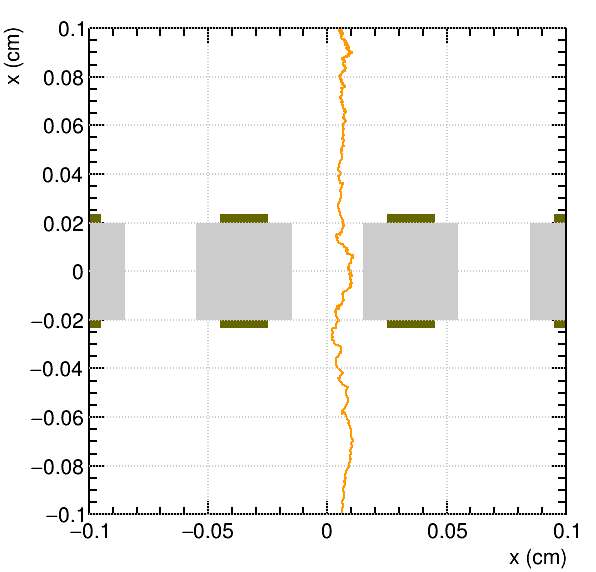

In [27]:
# Plot the geometry and drift line.
cGeom = ROOT.TCanvas("geom", "Geometry")
viewMesh = ROOT.Garfield.ViewFEMesh()
viewMesh.SetArea(-axis_x, -axis_z, -axis_y, axis_x, axis_z, axis_y)
viewMesh.SetCanvas(cGeom)
viewMesh.SetComponent(elm)
viewMesh.SetPlane(0, -1, 0, 0, 0, 0)
viewMesh.SetFillMesh(True)
viewMesh.SetColor(1,ROOT.kGray)
viewMesh.SetColor(2,ROOT.kYellow + 3)
viewMesh.SetColor(3,ROOT.kYellow + 3)
viewMesh.EnableAxes()
viewMesh.SetXaxisTitle("x (cm)")
viewMesh.SetYaxisTitle("x (cm)")
viewMesh.SetViewDrift(viewDrift)
viewMesh.Plot()
cGeom.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: fields


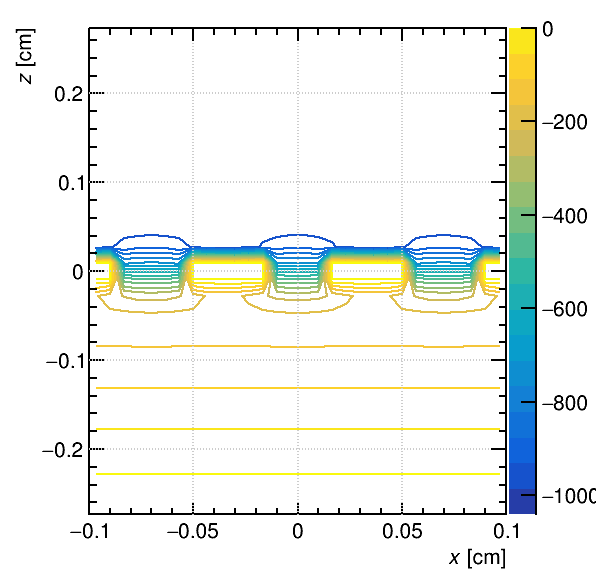

In [28]:
# Plot the fields.
cFields = ROOT.TCanvas("fields", "Fields")
viewField = ROOT.Garfield.ViewField()
viewField.SetSensor(sensor)
viewField.SetCanvas(cFields)
viewField.SetArea(-axis_x, -axis_z, axis_x, axis_z)
viewField.SetNumberOfContours(20)
viewField.SetNumberOfSamples2d(30, 30)
viewField.SetPlane(0, -1, 0, 0, 0, 0)
viewField.PlotContour("v")
cFields.Draw()